In [ ]:
! pip install segmentation_models_pytorch albumentations
! pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import albumentations
import torchvision 
import random
import segmentation_models_pytorch as smp

In [ ]:
#Mount Google Drive with test dataset
from google.colab import drive
drive.mount('/content/drive/')

#Define pathes to images and corresponding masks intended to test model
testpath_images = '/content/drive/MyDrive/project/test_images_512x512_npy/images/'
testpath_masks = '/content/drive/MyDrive/project/test_images_512x512_npy/masks/'

#Collect all pathes to images and masks in two lists
masks = [os.path.join(testpath_masks, i) for i in os.listdir(testpath_masks)]
imgs = [os.path.join(testpath_images, i) for i in os.listdir(testpath_images)]

#Sort pathes to images and masks in order images correspond to masks
masks.sort()
imgs.sort()

#Check out size of test dataset
df = pd.DataFrame({"image":imgs, "mask":masks})
print(df.values.shape)

Mounted at /content/drive/
(1434, 2)


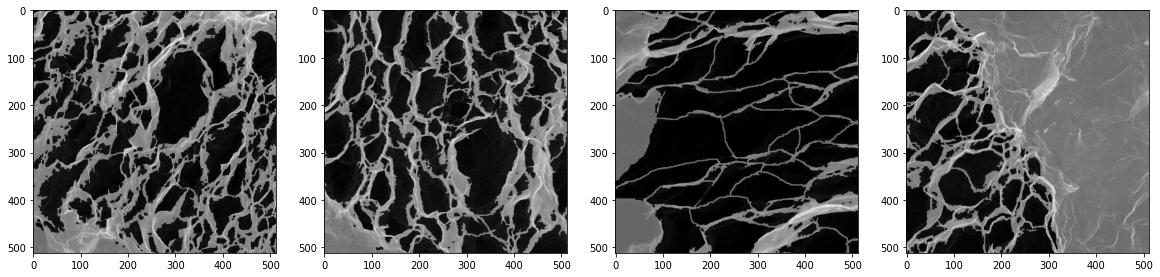

In [ ]:
#Plot some images with superimposed corresponding masks
rows, cols = 1, 4
fig = plt.figure(figsize = (20, 20))
for i in range(1, rows * cols + 1):
    idx = random.randint(0, len(df))
    fig.add_subplot(rows, cols, i)
    img_path = df['image'][idx]
    msk_path = df['mask'][idx]
    plt.imshow(np.load(img_path), cmap = 'gray')
    plt.imshow(np.load(msk_path), alpha = 0.4, cmap = 'gray')
plt.show()

In [ ]:
def convert_to_tensor(x, **kwargs):
    """
    Reshape numpy tensor from (H, W) to (C=1, H, W).
    
    Parameters
    ----------
    x: ndarray of shape (H, W).
        Image in tensor form.

    Returns
    -------
    ndarray of shape (C=1, H, W).
        Reshaped image in tensor form.
    """

    return np.expand_dims(x, axis=0).astype("float32")


def func_for_preprocessing(preprocessing_fn=None):
    """
    Generates a set of albumentations' transforms to preprocess images.
    
    Parameters
    ----------
    preprocessing_fn: function, optional, default=None
        Function used to preprocess raw images.

    Returns
    -------
    An instance of albumentations' Compose class containing preprocessing functions.
    """

    transform = []
    if preprocessing_fn:
        transform.append(albumentations.Lambda(image=preprocessing_fn))
    transform.append(albumentations.Lambda(image=convert_to_tensor, mask=convert_to_tensor))
    return albumentations.Compose(transform)


def testaugs():
    """
    Generates a set of albumentations' transforms to augment test dataset.
    
    Returns
    -------
    An instance of albumentations' Compose class containing augmenting functions.
    """

    transform = [
                albumentations.HorizontalFlip(p=0.5),
                albumentations.VerticalFlip(p=0.5),
            ]
    return albumentations.Compose(transform)


class MyDataset(Dataset):
    """
    Class used to represent test dataset applying preprocessing and augmentation.
    
    Attributes
    ----------
    imagespath: list of length N.
        Contains all pathes to raw images.
    maskspath: list of length N.
        Contains all pathes to raw masks.
    augment: albumentations' Compose class, optional, default=None.
        Contains augmenting functions.
    preprocess: albumentations' Compose class, optional, default=None.
        Contains preprocessing functions.        
    """

    def __init__(self, imagespath, maskspath, augment=None, preprocess=None):
        self.imagespath = imagespath
        self.maskspath = maskspath
        self.augment = augment
        self.preprocess = preprocess

        
    def __len__(self):
        """
        Measures object's length (dataset size).

        Returns
        -------
        int.
            Dataset size.
        """

        return len(self.imagespath)

    
    def __getitem__(self, idx):
        """
        Opens, augments, preprocesses and returns idx-th tuple of image and mask.

        Parameters
        ----------
        idx: int.
            Index number of image and corresponding mask.

        Returns
        -------
        Tuple of length 2.
            Augmented and preprocessed image and corresponding mask.
        """

        #Open npy-files with image and mask
        image = np.load(self.imagespath[idx])
        mask = np.load(self.maskspath[idx])
        
        #Augment image and mask
        if self.augment:
            sample = self.augment(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        #Preprocess image and mask
        if self.preprocess:
            sample = self.preprocess(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

In [ ]:
#Define encoder, activation function and path to model weights
encoder = 'efficientnet-b4'
activation = 'sigmoid'
modelpath = '/content/drive/MyDrive/project/best_model_FPN_efficientnet-b4_ep100_bs11_wc_wlrsch_lr0_001_imagenet.pth'

#Define model and load model weights
model = smp.FPN(encoder_name=encoder, activation=activation, encoder_weights=None, encoder_depth=5, in_channels=1)
model.load_state_dict(torch.load(modelpath))

#Define preprocessing function and construct test pytorch dataset applying augmentation 
preprocess_func = None
testdata = MyDataset(imagespath = df['image'].tolist(),
                           maskspath = df['mask'].tolist(),
                           augment = testaugs(),
                           preprocess = func_for_preprocessing(preprocess_func))

#Define batch size and construct test pytorch dataloader
batch_size = 11
testloader = DataLoader(testdata, batch_size = batch_size, shuffle=True)

In [ ]:
#Define number of test epoches, device, loss function, other metrics of interest
epochs = 1
device = "cuda"
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]

#Initialize test epoch
testepoch = smp.utils.train.ValidEpoch(model, loss=loss, metrics=metrics, device=device, verbose=True)

In [ ]:
#Run test process
test_logs_list = []
best_result = 0.0
for i in range(0, epochs):
    print('\nEpoch: {}'.format(i))
    testlogs = testepoch.run(testloader)
    test_logs_list.append(testlogs)


Epoch: 0
valid: 100%|██████████| 131/131 [15:44<00:00,  7.21s/it, dice_loss - 0.06606, iou_score - 0.8765]


In [ ]:
#Check out test metrics and loss function values
test_logs_df = pd.DataFrame(test_logs_list)
test_logs_df.T

,0
dice_loss,0.066057
iou_score,0.876537
